# Modulation classification using dilated 1D convolutions

Model takes ideas from Temporal Convolutional Networks (TCN), [arXiv:1803.01271 [cs.LG]](https://arxiv.org/abs/1803.01271)

However, since whole sequence is presented at once, the model does not use causal convolutions. In addition, batch normalization instead of weight normalization is used.

Dataset:
    
Utrilla, Ramiro (2020), "MIGOU-MOD: A dataset of modulated radio signals acquired with MIGOU, a low-power IoT experimental platform", Mendeley Data, V1, doi: 10.17632/fkwr8mzndr.1

https://data.mendeley.com/datasets/fkwr8mzndr/1

This dataset includes over-the-air measurements of real radio signals modulated with 11 different modulations. These signals were generated by a transmitter formed by a USRP B210 connected to a computer with GNU Radio. On the receiver side, the MIGOU platform has been used to record the signals. All measurements were carried out indoors, in an office environment. Specifically, measurements were taken at two distances from the transmitter, 1 and 6 meters, which corresponds to average Signal-to-Noise Ratios (SNRs) of 37 dB and 22 dB respectively.

## Configuration

Imports

In [1]:
from pathlib import Path
from collections import defaultdict
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.handlers
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR = Path('./data')
DATASET_FILE = DATA_DIR / 'migou_dataset_19.08_400000x128.pkl'

MODELS_DIR = Path('./models')

VAL_RATIO = 0.2

BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
def load_data(dataset_path):
    print("Loading data...", end=' ', flush=True)
    with open(dataset_path, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1')

    print("Done.", flush=True)
    return dataset

In [5]:
def train_val_split(dataset, modulations):
    train_data = []
    val_data = []
    train_labels = []
    val_labels = []

    num = 0
    for k, data in tqdm(dataset.items()):
        x_train, x_val = train_test_split(data, test_size=VAL_RATIO, random_state=num, shuffle=True)
        mod = modulations.searchsorted(k[0])
        y_train = np.full(len(x_train), mod)
        y_val = np.full(len(x_val), mod)
        
        train_data.append(x_train)
        train_labels.append(y_train)
        val_data.append(x_val)
        val_labels.append(y_val)
        num += 10
    
    train_data = torch.as_tensor(np.concatenate(train_data, axis=0), dtype=torch.float)
    train_labels = torch.as_tensor(np.concatenate(train_labels, axis=0), dtype=torch.long)
    val_data = torch.as_tensor(np.concatenate(val_data, axis=0), dtype=torch.float)
    val_labels = torch.as_tensor(np.concatenate(val_labels, axis=0), dtype=torch.long)
    
    return train_data, train_labels, val_data, val_labels

In [6]:
def prepate_data(dataset_path):
    dataset = load_data(dataset_path)
    modulations = np.unique([x[0] for x in dataset.keys()])
    train_data, train_labels, val_data, val_labels = train_val_split(dataset, modulations)
    return train_data, train_labels, val_data, val_labels, modulations

In [7]:
def dataset_plot(dset, idx, modulations):
    X, Y = dset[idx]
    title = f"Ground truth: {modulations[Y]}"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.moveaxis(X.numpy(), 0, -1),'.-')
    ax.set_title(title)
    plt.grid()
    plt.show()

In [8]:
train_data, train_labels, val_data, val_labels, modulations = prepate_data(DATASET_FILE)

Loading data... Done.


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  8.28it/s]


In [9]:
print("Number of train samples: {:,}".format(len(train_data)))
print("Number of val samples: {:,}".format(len(val_data)))

Number of train samples: 7,040,000
Number of val samples: 1,760,000


In [10]:
print(modulations)

['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [11]:
train_dset = torch.utils.data.TensorDataset(train_data, train_labels)
val_dset = torch.utils.data.TensorDataset(val_data, val_labels)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)

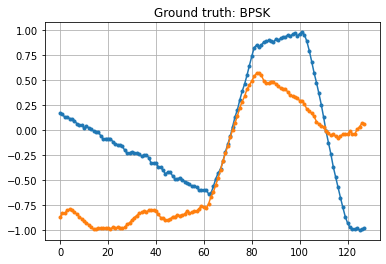

In [13]:
dataset_plot(val_dset, 0, modulations)

## Model

Model is similar to TCN, [arXiv:1803.01271 [cs.LG]](https://arxiv.org/abs/1803.01271)

Utilities

In [14]:
def init_linear(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [15]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, act=True):
        padding = dilation * (kernel_size - 1) // 2
        layers = [
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

Model

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, p_drop=0.):
        super().__init__()
        self.residual = nn.Sequential(
            ConvBlock(in_channels, out_channels, kernel_size, dilation=dilation),
            nn.Dropout(p_drop),
            ConvBlock(out_channels, out_channels, kernel_size, dilation=dilation, act=False),
            nn.Dropout(p_drop)
        )
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.act = nn.ReLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [17]:
class Stack(nn.Sequential):
    def __init__(self, in_channels, channels, kernel_size, dilation_depth, p_drop=0.):
        layers = []
        dilation = 1
        
        for num in range(0, dilation_depth + 1):
            layers.append(ResidualBlock(in_channels, channels, kernel_size, dilation, p_drop))
            in_channels = channels
            dilation = dilation * 2
        
        super().__init__(*layers)

In [18]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [19]:
class Net(nn.Sequential):
    def __init__(self, classes, in_channels, channels, kernel_size, dilation_depth,
                 res_p_drop=0., head_p_drop=0.):
        super().__init__(
            Stack(in_channels, channels, kernel_size, dilation_depth, res_p_drop),
            Head(channels, classes, p_drop=head_p_drop)
        )

Model creation

In [20]:
model = Net(classes=len(modulations), in_channels=2, channels=32, kernel_size=3, dilation_depth=6,
            res_p_drop=0., head_p_drop=0.1)

In [21]:
model.apply(init_linear);

In [22]:
model.to(DEVICE);

In [23]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 41,522


## Training

### Setup trainer

In [24]:
loss = nn.CrossEntropyLoss()

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [26]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

Trainer

In [27]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [28]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [29]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [30]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [31]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [32]:
history = defaultdict(list)

In [33]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [34]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/10 - train: loss 0.209; val: loss 0.193 accuracy 0.905
2/10 - train: loss 0.190; val: loss 0.182 accuracy 0.908
3/10 - train: loss 0.187; val: loss 0.257 accuracy 0.883
4/10 - train: loss 0.183; val: loss 0.189 accuracy 0.906
5/10 - train: loss 0.172; val: loss 0.214 accuracy 0.904
6/10 - train: loss 0.156; val: loss 0.148 accuracy 0.924
7/10 - train: loss 0.140; val: loss 0.169 accuracy 0.917
8/10 - train: loss 0.123; val: loss 0.122 accuracy 0.938
9/10 - train: loss 0.104; val: loss 0.100 accuracy 0.950
10/10 - train: loss 0.089; val: loss 0.090 accuracy 0.956


In [35]:
torch.save(model.state_dict(), MODELS_DIR / 'model_final.pt')

### Plotting

In [36]:
def plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [37]:
def plot_history(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

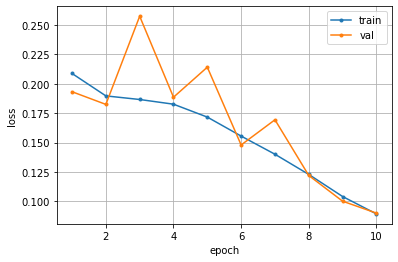

In [38]:
plot_train_val(history, 'loss')

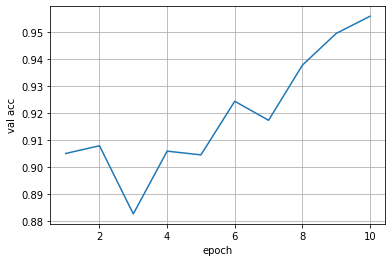

In [39]:
plot_history(history, 'val acc')

## Testing

In [40]:
model.load_state_dict(torch.load(MODELS_DIR / 'model_final.pt'))

<All keys matched successfully>

In [41]:
model.eval();

In [42]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
predictions = []
gt_labels = []

for X, Y in tqdm(val_loader):
    X = X.to(DEVICE)
    output = model(X)
    output = output.detach().cpu()
    Y_pred = torch.argmax(output, dim=1)
    predictions.append(Y_pred)
    gt_labels.append(Y)

100%|██████████████████████████████████████| 6875/6875 [00:21<00:00, 326.06it/s]


In [44]:
predictions = torch.cat(predictions)
predictions = predictions.numpy()

In [45]:
gt_labels = torch.cat(gt_labels)
gt_labels = gt_labels.numpy()

In [46]:
cm = confusion_matrix(gt_labels, predictions)

In [47]:
print( "Accuracy {:.3f}".format( np.sum(np.diag(cm)) / np.sum(cm) ))

Accuracy 0.956


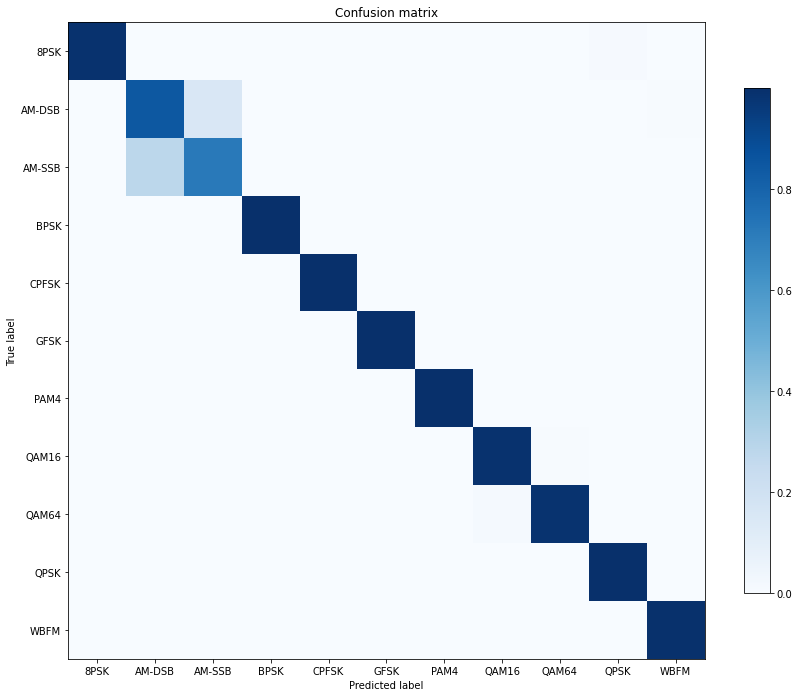

In [48]:
plot_confusion_matrix(cm, labels=modulations)